In [1]:
# My thesis project involves using light curves from target stars from the K2 missions
#
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import upsilon
from astropy.io import fits
from astropy.table import Table
from pathlib import Path
import csv

-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


In [2]:
# A tutorial on how to download the corrected light curves can be found here: [https://www.cfa.harvard.edu/~avanderb/tutorial/tutorial3.html]
# Using ADQL (a variant of SQL) I queried stars within a 30' arcminute radius from the center of NGC 1817
# The following .txt file contains the URL's of the target stars queried.

target_star_query = pd.read_csv(r"C:/Users/Rigo/Downloads/k2sff.txt", header = None)

# And we're going to use the wget library to download all of our stars from the Mikulski Archive for Space Telescopes
for row in range(len(target_star_query)):
    url = target_star_query[0][row]
    wget.download(url)

100% [..........................................................................] 3360960 / 3360960

In [3]:
# Each star's data has been uploaded as a .fits file containing photographic data for each aperature on the K2 Satellite
# The data has already been processed meaning that NASA tells us which aperature we want: BESTAPER
star_1 = fits.open(r"C:/Users/Rigo/Downloads/Astro/hlsp_k2sff_k2_lightcurve_246885312-c13_kepler_v1_llc.fits")
star_1.info()

Filename: C:/Users/Rigo/Downloads/Astro/hlsp_k2sff_k2_lightcurve_246885312-c13_kepler_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   ()      
  1  BESTAPER      1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  2  CIRC_APER0    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  3  CIRC_APER1    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  4  CIRC_APER2    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  5  CIRC_APER3    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  6  CIRC_APER4    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  7  CIRC_APER5    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  8  CIRC_APER6    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
  9  CIRC_APER7    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
 10  CIRC_APER8    1 BinTableHDU    242   3605R x 6C   [D, D, D, D, I, J]   
 11  CIRC_APER9    

In [4]:
# Taking a look at what's inside BESTAPER:
# The columns most important to us are T (time) and FCOR (Corrected Flux) 
# Each K2 Campaign last for 80 days and luminosity is measured in terms of flux
# Flux = difference from the mean level of luminosity - This makes it easy to compare stars with vastly different levels of brightness
print(star_1[1].columns)

ColDefs(
    name = 'T'; format = 'D'
    name = 'FRAW'; format = 'D'
    name = 'FCOR'; format = 'D'
    name = 'ARCLENGTH'; format = 'D'
    name = 'MOVING'; format = 'I'
    name = 'CADENCENO'; format = 'J'
)


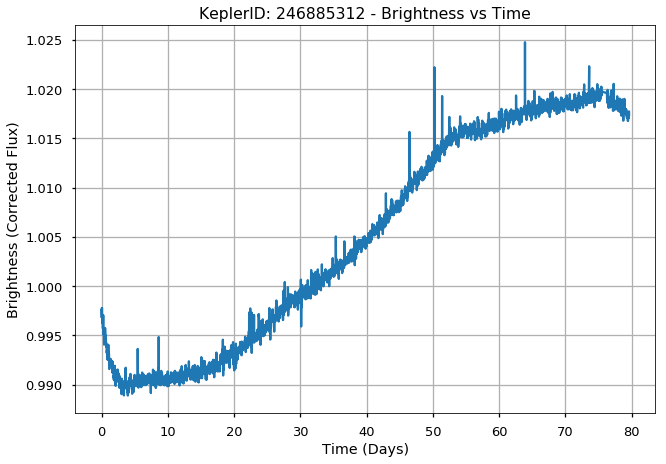

In [5]:
#You can see that for this star, a longer viewing period would have been ideal - we capture about half of the star's cycle
star_1_data = Table(star_1[1].data)
days = star_1_data['T'] - 2988.52
with plt.style.context('seaborn-talk'):
    lum = plt.plot(days, star_1_data['FCOR'])
    plt.xlabel('Time (Days)')
    plt.ylabel('Brightness (Corrected Flux)')
    plt.title('KeplerID: 246885312 - Brightness vs Time')
    plt.grid(True)
    plt.savefig("test.png")
    plt.show()

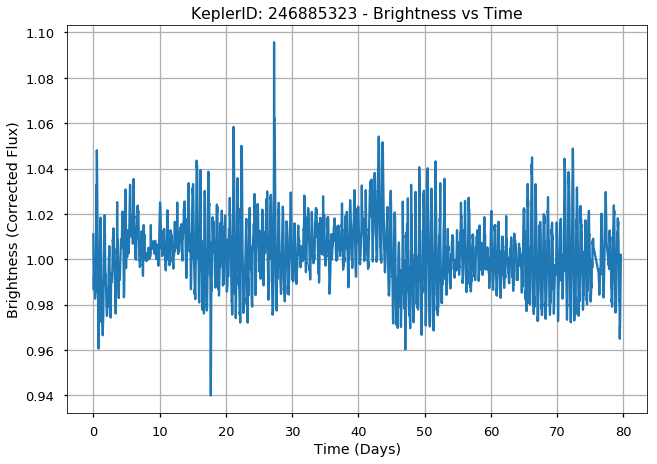

In [6]:
# This star is much nosier but there might be a variable star with a distinct, repeating pattern beneath that noise
star_2 = fits.open(r"C:/Users/Rigo/Downloads/Astro/hlsp_k2sff_k2_lightcurve_246887060-c13_kepler_v1_llc.fits")
star_2_data = Table(star_2[1].data)
days = star_2_data['T'] - 2988.52
with plt.style.context('seaborn-talk'):
    lum = plt.plot(days, star_2_data['FCOR'])
    plt.xlabel('Time (Days)')
    plt.ylabel('Brightness (Corrected Flux)')
    plt.title('KeplerID: 246885323 - Brightness vs Time')
    plt.grid(True)
    plt.savefig("test.png")
    plt.show()

In [7]:
# Writing a csv file function
def csv_writer(data, file):
    """
    Write data to a CSV file path
    """
    with open(file, 'w') as csvfile:
        writer=csv.writer(csvfile, delimiter=',')
        writer.writerows(zip(data))

In [8]:
# We can use UPSILoN to classify our stars instead of trying to make a guessing game out of it.
# UPSILoN (Automated Classification of Periodic Variable Srars using Machine Learning)was developed by Kim & Bailer Jones
# They developed this algorithm to extract variability features from the light curve and classify it based on its features
# You can read more about it here: https://github.com/dwkim78/upsilon

# Loading the model
rf_model = upsilon.load_rf_model()

#Create lists that we'll aggregate into a dataframe soon
star_list = []
label_list = []
probability_list = []
flag_list = []

# Running the loop through all .fits files in our directory
pathlist = Path(r"C:/Users/Rigo/Downloads/").glob('**/*.fits')
for path in pathlist:
    path_in_str = str(path)
    star = fits.open(path_in_str)
    star_data = Table(star[1].data)
    
    # Create vectors for time series and magnitude measurements
    mag = np.array(star_data['FCOR'])
    date = np.array(star_data['T'] - 2988.52)
    
    #Extract features that will be used in the random forest classifier
    e_features = upsilon.ExtractFeatures(date, mag)
    e_features.run()
    features = e_features.get_features()
    
    # Classify the light curve
    label, probability, flag = upsilon.predict(rf_model, features)
    
    # Append lists with results
    star_list.append(path_in_str)
    label_list.append(label)
    probability_list.append(probability)
    flag_list.append(flag)

C:\Users\Rigo\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Rigo\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Rigo\Anaconda3\lib\site-packages\upsilon\extract_features\extract_features.py:204: RuntimeWarning: divide by zero encountered in log10
  np.log10(pLS.getSignificance(fx, fy, nout, oversampling)[jmax])


In [9]:
# Let's put it into 1 dataframe
results = pd.DataFrame(
        {'star': star_list,
         'label': label_list,
         'probability': probability_list,
         'flag': flag_list
        })
results

,star,label,probability,flag
0,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,DSCT,0.50,0
1,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,LPV_OSARG_RGB,0.49,0
2,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,EB_ESD,0.42,0
3,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,EB_ED,0.35,0
4,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,DSCT,0.57,0
5,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,DSCT,0.56,0
6,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,NonVar,0.50,0
7,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,EB_ED,0.43,0
8,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,DSCT,0.52,0
9,C:\Users\Rigo\Downloads\Astro\hlsp_k2sff_k2_li...,DSCT,0.42,0


In [10]:
# And give them a proper id
ID = results['star']
f = lambda x: x["star"].split("_", )
ID = pd.DataFrame(results.apply(f, axis=1).tolist())
results['star'] = ID[4]
results

,star,label,probability,flag
0,246885312-c13,DSCT,0.50,0
1,246885323-c13,LPV_OSARG_RGB,0.49,0
2,246886144-c13,EB_ESD,0.42,0
3,246886785-c13,EB_ED,0.35,0
4,246886811-c13,DSCT,0.57,0
5,246886881-c13,DSCT,0.56,0
6,246887060-c13,NonVar,0.50,0
7,246887076-c13,EB_ED,0.43,0
8,246887150-c13,DSCT,0.52,0
9,246887610-c13,DSCT,0.42,0


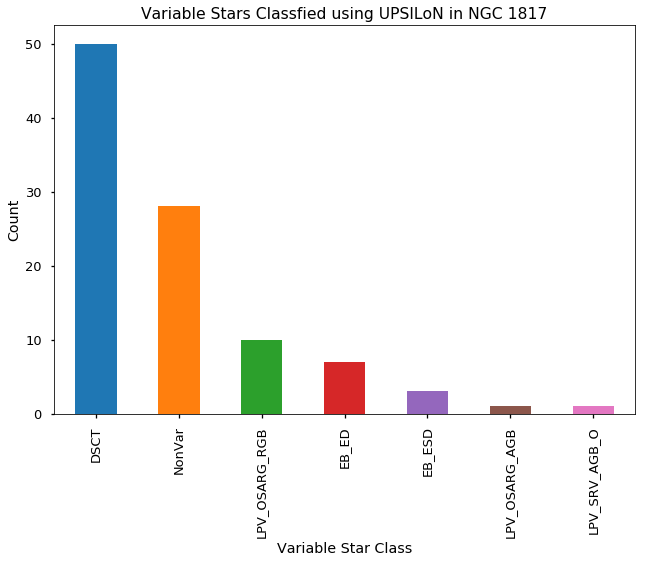

In [20]:
# We identified 50 Delta Scuti variable stars, 12 Long Period Variables, 10 Eclipising Binaries and 28 Non variables
slabel_counts = results['label'].value_counts()
with plt.style.context('seaborn-talk'):
    slabel_counts.plot(kind='bar')
    plt.xlabel('Variable Star Class')
    plt.ylabel('Count')
    plt.title('Variable Stars Classfied using UPSILoN in NGC 1817')
    plt.show()

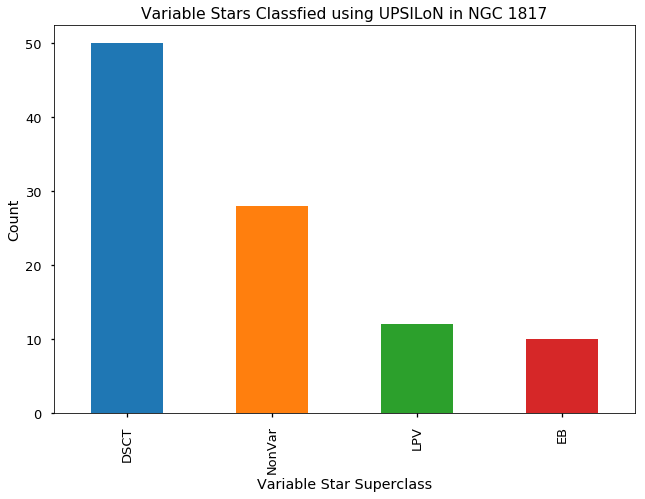

In [12]:
# The classifier tends to lose much of its accuracy when it tries to identify specific class
# We can identify just superclasses to make the data easier to reead
superclass = results['label']
g = lambda x: x["label"].split("_", )
superclass = pd.DataFrame(results.apply(g, axis=1).tolist())
results["superclass"] = superclass[0]

slabel_counts = results['superclass'].value_counts()
with plt.style.context('seaborn-talk'):
    slabel_counts.plot(kind='bar')
    plt.xlabel('Variable Star Superclass')
    plt.ylabel('Count')
    plt.title('Variable Stars Classfied using UPSILoN in NGC 1817')
    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024287F39A90>]],
      dtype=object)

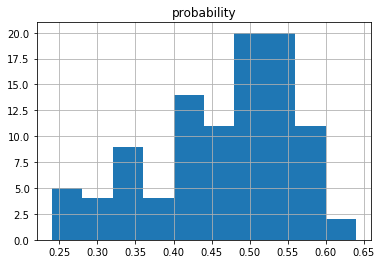

In [22]:
# And we can see that they range from a 0.20 - 0.65 probability
# Probability refers to the proportion of random forest decision trees that selected the most voted class
results.hist(column="probability")

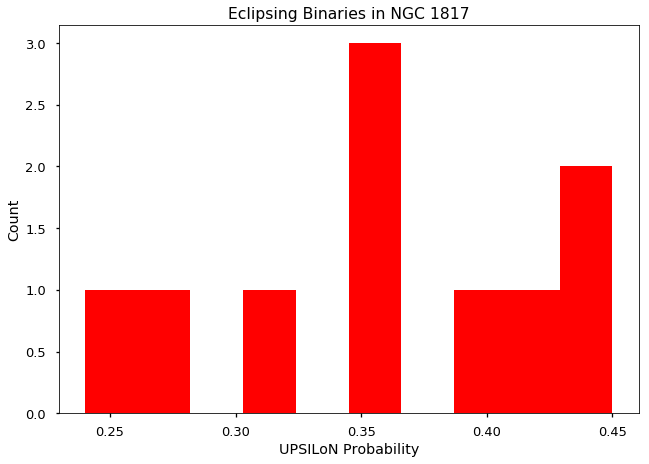

In [14]:
DSCT = results[results['superclass'].str.match('DSCT')]
LPV = results[results['superclass'].str.match('LPV')]
EB = results[results['superclass'].str.match('EB')]

with plt.style.context('seaborn-talk'):
    figure = EB['probability'].plot.hist(histtype="stepfilled", bins=10, color = 'red')
    plt.xlabel('UPSILoN Probability')
    plt.ylabel('Count')
    plt.title('Eclipsing Binaries in NGC 1817')
    plt.show()

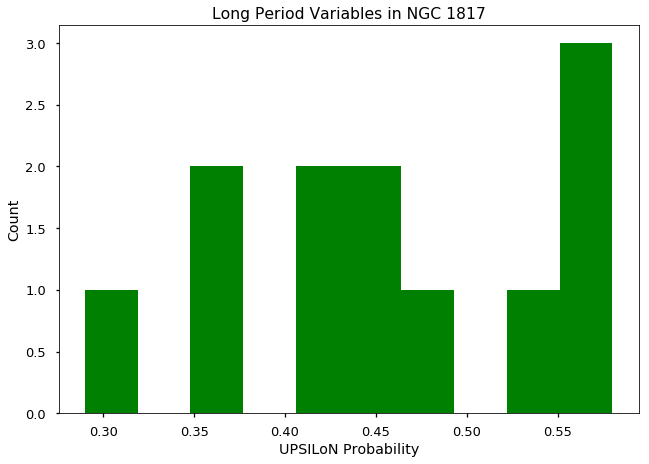

In [15]:
with plt.style.context('seaborn-talk'):
    figure = LPV['probability'].plot.hist(histtype="stepfilled", bins=10, color = 'green')
    plt.xlabel('UPSILoN Probability')
    plt.ylabel('Count')
    plt.title('Long Period Variables in NGC 1817')
    plt.show()

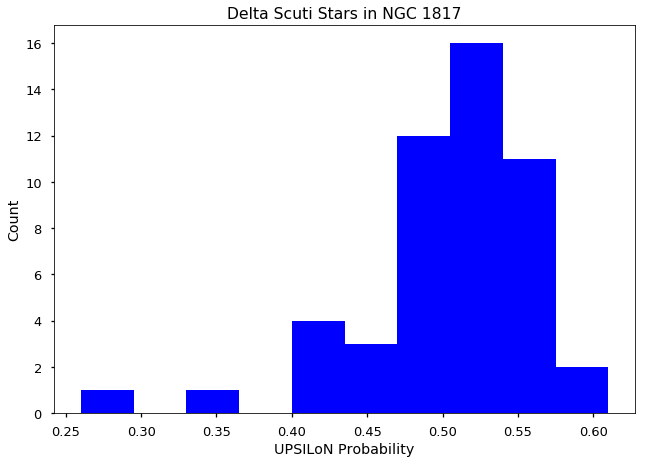

In [16]:
with plt.style.context('seaborn-talk'):
    figure = DSCT['probability'].plot.hist(histtype="stepfilled", bins=10, color = 'blue')
    plt.xlabel('UPSILoN Probability')
    plt.ylabel('Count')
    plt.title('Delta Scuti Stars in NGC 1817')
    plt.show()

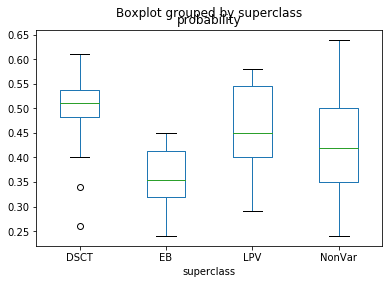

In [23]:
# A quick look at the probability distributions tells us that Delta Scuti's are a more recognizable than Eclipsing Binaries
# Also that Non Variables have the widest range of uncertainity
results.boxplot(column="probability", by = "superclass", grid=False)